In [1]:
import numpy as np

In [2]:
train_preds = np.load("/g/data/x77/jm0124/feature_vectors/feature-array-outputs-uv-train.npy")[:,[0,1]]
val_preds   = np.load("/g/data/x77/jm0124/feature_vectors/feature-array-outputs-uv-val.npy")  [:,[0,1]]
test_preds  = np.load("/g/data/x77/jm0124/feature_vectors/feature-array-outputs-uv-test.npy") [:,[0,1]]

In [3]:
import json
def load_labels(f):
    with open(f, 'r') as f2:
        j = json.load(f2)
    ids = j.keys()
    labels = []
    latent = []
    for id_ in ids:
        # JSON object has label: [[long_old, long_new], [lat, lat], [inten, inten]],
        # time: int, index: int
        long, lat, inten = j[id_]['label']
        labels.append([long[1] - long[0], lat[1] - lat[0]])
        latent.append([long[0], lat[0], inten[0]])
    return np.array(labels), np.array(latent)

train_labels, train_latent = load_labels("/g/data/x77/jm0124/feature_vectors/train_feature_labels.json")
val_labels,   val_latent   = load_labels("/g/data/x77/jm0124/feature_vectors/val_feature_labels.json")
test_labels,  test_latent  = load_labels("/g/data/x77/jm0124/feature_vectors/test_feature_labels.json")

In [4]:
assert train_preds.shape == train_labels.shape
assert val_preds.shape == val_labels.shape
assert test_preds.shape == test_labels.shape
print(train_preds.shape)

(166686, 2)


In [5]:
# confirm least squares error is pretty small on the training set as a sanity check to ensure the data is all lined up nicely
# filter out big error terms due to not handling wrapping longitude
mse = np.square(train_labels - train_preds)
mse = mse[mse < 50]
np.mean(mse)

0.32751523481304934

We now know that everything is loaded correctly. We're just using the position and intensity as latent metadata variables to condition our covariance on

In [6]:
import math
def log_zeromean_multivariate_normal_pdf(x, cov):
    k = cov.shape[0]
    return -0.5 * (k * math.log(2*math.pi) + math.log(np.linalg.det(cov)) + x.T @ np.linalg.pinv(cov) @ x)

In [7]:
def neg_log_likelihood(p, pred_cov):
    preds = np.array([pred_cov(p, latent_) for latent_ in train_latent])
    # quadratic term inside the multivariate normal PDF
    # this is proportional to log N(x|0,cov)
    scaled_p_values = []
    failed = 0
    for x, cov in zip(train_preds, preds):
        if np.linalg.det(cov) > 0:
            scaled_p_values.append(log_zeromean_multivariate_normal_pdf(x, cov))
        else:
            failed += 1
            scaled_p_values.append(-999999)
    return -np.array(scaled_p_values).mean() # negate so fmin maximises likelihood

In [8]:
from scipy.optimize import fmin

# covariance function
# takes a vector of parameters and latent variables to compute
# cov[residuals|latent]
def pred_cov(p, latent):
    # latent = [old_long, old_lat, old_intensity]
    # p = vector of parameters
    w, b = p[0:3], p[3:6]
    a, b, c = (w @ latent + b).tolist()
    return np.array([[a,b],[b,c]])

# this takes too long: computing maximum likelihood takes a minute each iteration
# we are also not sure what to choose for our covariance function
# as a linear model does not necessarily result in a positive semidefinite estimate
p0 = np.array([1,1,1,0,0,0])
#p = fmin(neg_log_likelihood, p0, args=(pred_cov,), maxiter=1)

Approach 2: the latent intensity variable is discrete and there are likely enough samples with each intensity to get an accurate conditional covariance estimate

First we bin samples by intensity and count the empirical distribution of intensities to ensure our sample sizes are big enough

Then we compute the sample covariance of the residuals in each partition with different intensity and compare them

In [36]:
from collections import defaultdict
def bin_by_intensity(preds, true, latent, mask):
    # returns a (default)dict where keys are intensities and values
    # are lists of (pred, true, latent) tuples where each is an ndarray
    intensities = latent[:,2]
    bins = defaultdict(list)
    for i in range(len(preds)):
        if mask[i]:
            bins[intensities[i]].append((preds[i],true[i],latent[i]))
    return bins

x = train_labels - train_preds
mask = abs(x.sum(axis=1)) < 90

train_bins = bin_by_intensity(train_preds, train_labels, train_latent, mask)

In [37]:
residuals_by_intensity = { inten:
    np.array([t[1]-t[0] for t in train_bins[inten]]) for inten in train_bins.keys() }

In [38]:
residuals_by_intensity[-5.0].shape

(20579, 2)

In [39]:
train_cov_by_intensity = {
    inten: np.cov(residuals_by_intensity[inten].T)
    for inten in train_bins.keys() }

In [40]:
train_cov_by_intensity

{-5.0: array([[ 0.73780072, -0.00918896],
        [-0.00918896,  0.40163592]]),
 -1.0: array([[0.33305253, 0.00634025],
        [0.00634025, 0.26599536]]),
 0.0: array([[0.33722213, 0.01629427],
        [0.01629427, 0.24951941]]),
 1.0: array([[0.32465   , 0.01249949],
        [0.01249949, 0.22263426]]),
 -3.0: array([[0.29289488, 0.0090092 ],
        [0.0090092 , 0.24511933]]),
 2.0: array([[0.29254337, 0.02256521],
        [0.02256521, 0.20548125]]),
 3.0: array([[0.23007182, 0.00999755],
        [0.00999755, 0.18949662]]),
 4.0: array([[0.19935086, 0.01755713],
        [0.01755713, 0.16861606]]),
 -2.0: array([[0.51676987, 0.00954464],
        [0.00954464, 0.28380496]]),
 -4.0: array([[1.72532972, 0.08907272],
        [0.08907272, 0.57256522]]),
 5.0: array([[0.18436625, 0.03798997],
        [0.03798997, 0.17438697]])}

Note: the plots below are 5000 random points sampled from the 0 mean 2d Gaussian with the sample covariance. They are not the actual points the 2d Gaussian was fit on

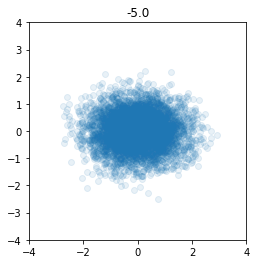

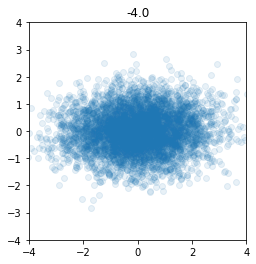

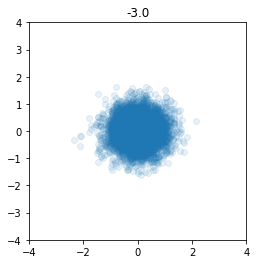

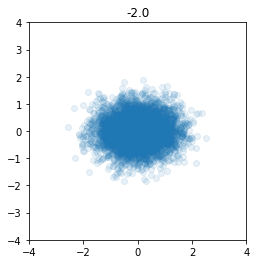

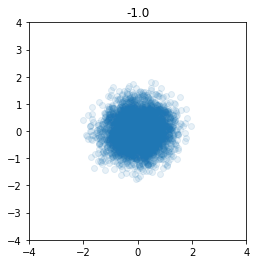

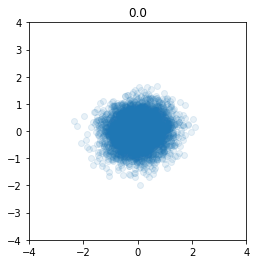

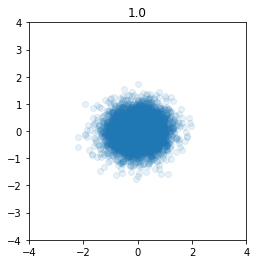

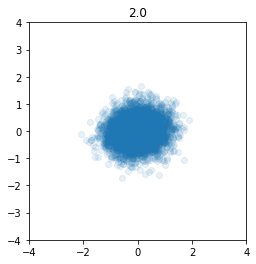

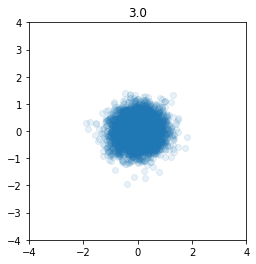

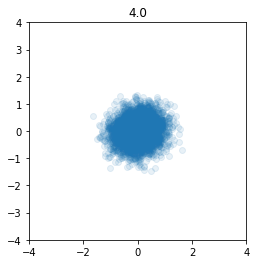

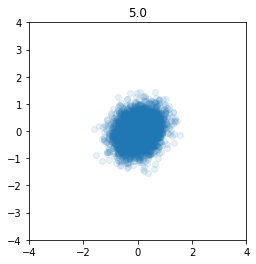

In [46]:
import matplotlib.pyplot as plt

def plot_cov(cov, inten):
    # plotting a countour is involved so we just sample a bunch
    x, y = np.random.multivariate_normal(np.zeros(2), cov, 5000).T
    plt.scatter(x, y, alpha=0.1)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(inten)
    plt.show()

for inten in sorted(list(train_cov_by_intensity.keys())):
    plot_cov(train_cov_by_intensity[inten], inten)

Scatter plot of all the residuals in the training set

In [32]:
x = train_labels - train_preds
x = x[abs(x.sum(axis=1)) < 90]
x.shape

(165329, 2)

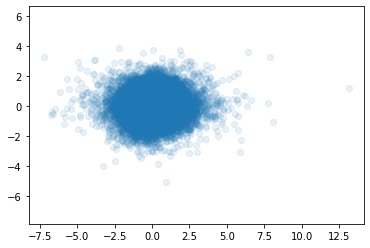

In [35]:
plt.scatter(x[:,0], x[:,1], alpha=0.1)
plt.axis('equal')
plt.show()

Scatter plot for each intensity partition

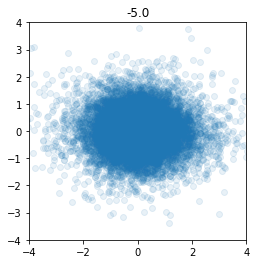

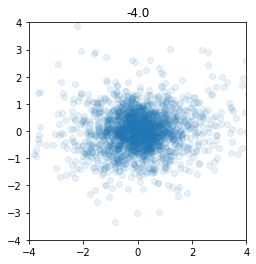

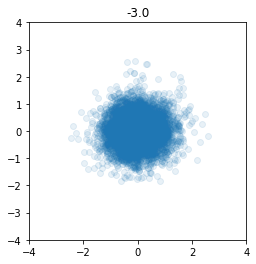

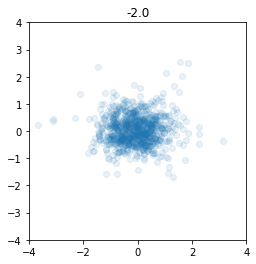

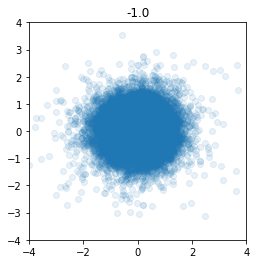

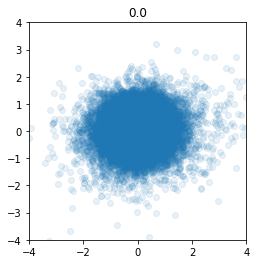

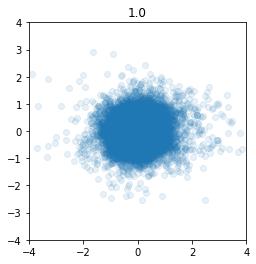

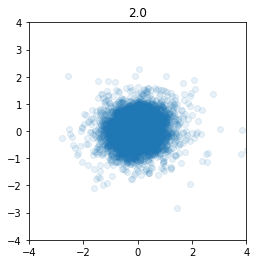

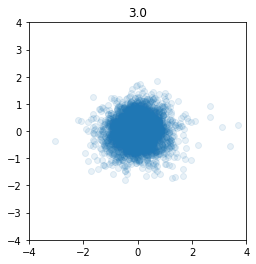

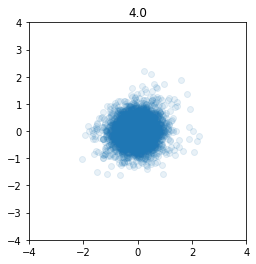

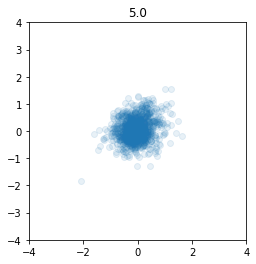

In [48]:
import matplotlib.pyplot as plt

def plot_inten(inten):
    x, y = residuals_by_intensity[inten].T
    plt.scatter(x, y, alpha=0.1)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(inten)
    plt.show()

for inten in sorted(list(train_cov_by_intensity.keys())):
    plot_inten(inten)

Hemisphere segregation (with intensity 1 because it's well behaved)

68% northern hemisphere


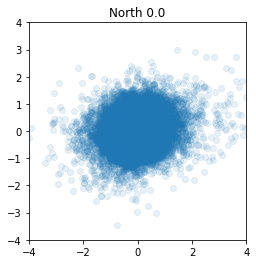

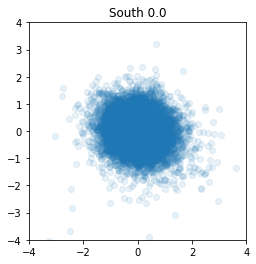

In [66]:
inten = 0.0
data = train_bins[inten]
north = [x for x in data if x[2][1] > 0]
north_bool = np.array([x[2][1] > 0 for x in data])
print(f"{len(north) / len(data):.0%} northern hemisphere")
x, y = residuals_by_intensity[inten][north_bool].T
plt.scatter(x, y, alpha=0.1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("North "+str(inten))
plt.show()
x, y = residuals_by_intensity[inten][np.array([not x for x in north_bool])].T
plt.scatter(x, y, alpha=0.1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("South "+str(inten))
plt.show()